In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from dtw import dtw
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

np.random.seed(42)

num_students = 100
num_semesters = 8
student_ids = [f"S{i+1:03d}" for i in range(num_students)]
semesters = [f"第{i+1}学期" for i in range(num_semesters)]

# # 1. 学业表现数据
# academic_data = []
# for sid in student_ids:
#     for sem in semesters:
#         academic_data.append({
#             '学生ID': sid,
#             '学期': sem,
#             '考试成绩': np.clip(np.random.normal(75, 15), 40, 100),
#             '课堂表现评分': np.clip(np.random.normal(80, 10), 50, 100),
#             '出勤率': np.round(np.random.uniform(0.5, 1.0), 2),
#             '学科竞赛获奖次数': np.random.binomial(2, 0.1)
#         })
# academic_df = pd.DataFrame(academic_data)
# academic_df.to_csv("academic_performance.csv", index=False)

# # 2. 图书馆与学习空间数据
# library_data = []
# base_date = datetime(2023, 3, 1)
# for sid in student_ids:
#     for _ in range(np.random.randint(20, 50)):
#         entry_time = base_date + timedelta(days=np.random.randint(0, 180), hours=np.random.randint(8, 20))
#         stay_duration = np.round(np.random.uniform(0.5, 6), 2)
#         library_data.append({
#             '学生ID': sid,
#             '入馆时间': entry_time.strftime("%Y-%m-%d %H:%M"),
#             '停留时长（小时）': stay_duration,
#             '借阅图书数量': np.random.randint(0, 5),
#             '座位号': f"{np.random.choice(['A', 'B', 'C', 'D'])}{np.random.randint(1, 50)}"
#         })
# library_df = pd.DataFrame(library_data)
# library_df.to_csv("library_usage.csv", index=False)

# # 3. 电子资源与网络学习数据
# digital_data = []
# for sid in student_ids:
#     for _ in range(np.random.randint(30, 60)):
#         digital_data.append({
#             '学生ID': sid,
#             '资源类型': np.random.choice(['文献下载', '电子书阅读', '在线课程观看']),
#             '访问日期': (base_date + timedelta(days=np.random.randint(0,180))).strftime("%Y-%m-%d"),
#             '使用时长（小时）': np.random.randint(0, 10)
#         })
# digital_df = pd.DataFrame(digital_data)
# digital_df.to_csv("digital_resources.csv", index=False)

# # 4. 社交学习与协作数据
# social_data = []
# for sid in student_ids:
#     for _ in range(np.random.randint(10, 30)):
#         social_data.append({
#             '学生ID': sid,
#             '互动类型': np.random.choice(['学习群发言', '小组协作', '师生互动']),
#             '互动次数': np.random.randint(1,10),
#             '互动日期': (base_date + timedelta(days=np.random.randint(0,180))).strftime("%Y-%m-%d")
#         })
# social_df = pd.DataFrame(social_data)
# social_df.to_csv("social_collaboration.csv", index=False)

# # 5. 个人背景与心理因素数据（脱敏）
# background_data = []
# for sid in student_ids:
#     background_data.append({
#         '学生ID': sid,
#         '城乡背景': np.random.choice(['城镇', '乡村']),
#         '家庭经济情况': np.random.choice(['困难', '一般', '较好']),
#         '学习动机评分': np.round(np.random.uniform(1, 5),2),
#         '焦虑水平评分': np.round(np.random.uniform(1, 5),2),
#         '自律性评分': np.round(np.random.uniform(1, 5),2)
#     })
# background_df = pd.DataFrame(background_data)
# background_df.to_csv("background_psychology.csv", index=False)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 数据导入
academic_df = pd.read_csv("academic_performance.csv")
library_df = pd.read_csv("library_usage.csv")
digital_df = pd.read_csv("digital_resources.csv")
social_df = pd.read_csv("social_collaboration.csv")
background_df = pd.read_csv("background_psychology.csv")

In [4]:
# 检查缺失值并清理异常数据
academic_df.dropna(inplace=True)
library_df.dropna(inplace=True)
digital_df.dropna(inplace=True)
social_df.dropna(inplace=True)

# library_data['entry_time'] = pd.to_datetime(library_data['entry_time'], format='%Y/%m/%d %H:%M')

# 剔除补考、重修的异常成绩数据（假设低于50分为补考、重修数据）
#academic_df = academic_df[academic_df["考试成绩"] >= 50]

# 剔除补考、重修的异常成绩数据（假设高于100分为错误数据）
#academic_df = academic_df[academic_df["考试成绩"] <= 100]

# 标记学习中断期（出勤率低于0.75视为学习中断期）
#academic_df["学习中断期"] = academic_df["出勤率"].apply(lambda x: True if x < 0.6 else False)

# 确认数据清洗效果
#print(academic_df.head(10))

数据加载并清洗完成！
合并后数据维度：(766, 20)
DTW 距离矩阵形状：(100, 100)
聚类标签数量：100
DataFrame 长度：766
聚类完成，各聚类人数：1    48
2    26
0    26
Name: count, dtype: int64

各类学习模式特征统计：
   cluster       平均成绩       成绩波动  平均图书馆时长  平均电子资源时长  平均互动次数    平均学习动机  \
0        0  78.367129   9.327769      0.0       0.0     0.0  2.897150   
2        2  78.266807  11.188827      0.0       0.0     0.0  3.041809   
1        1  76.812272   8.119926      0.0       0.0     0.0  3.077302   

      平均自律性  学习中断次数  
0  3.097900      48  
2  3.332965      42  
1  2.964905      70  


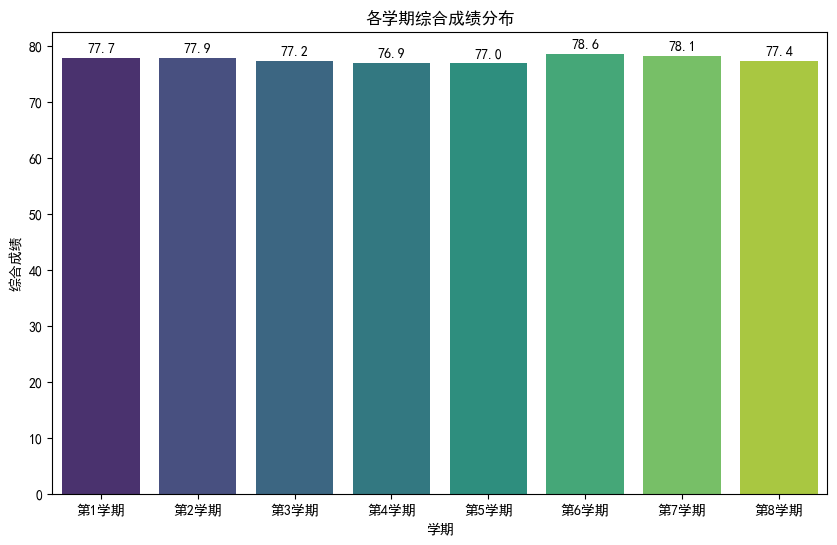

<Figure size 1200x1000 with 0 Axes>

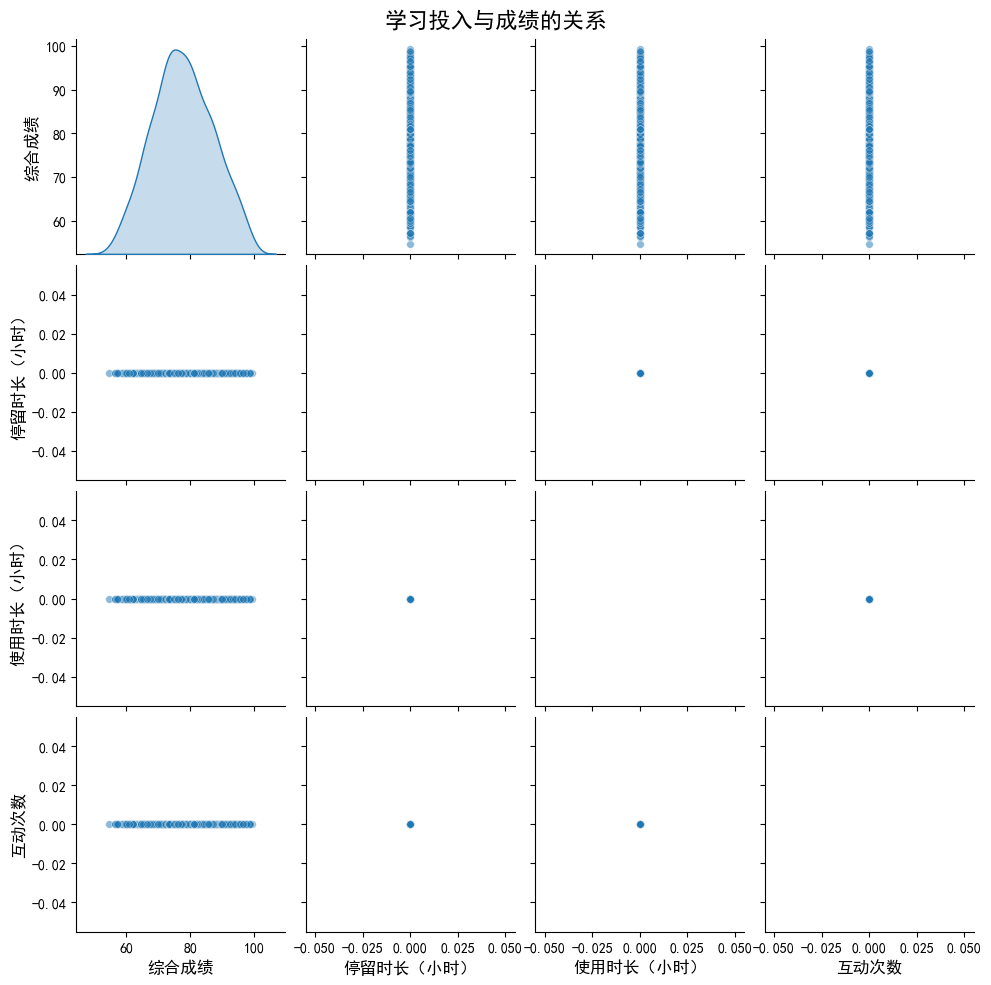

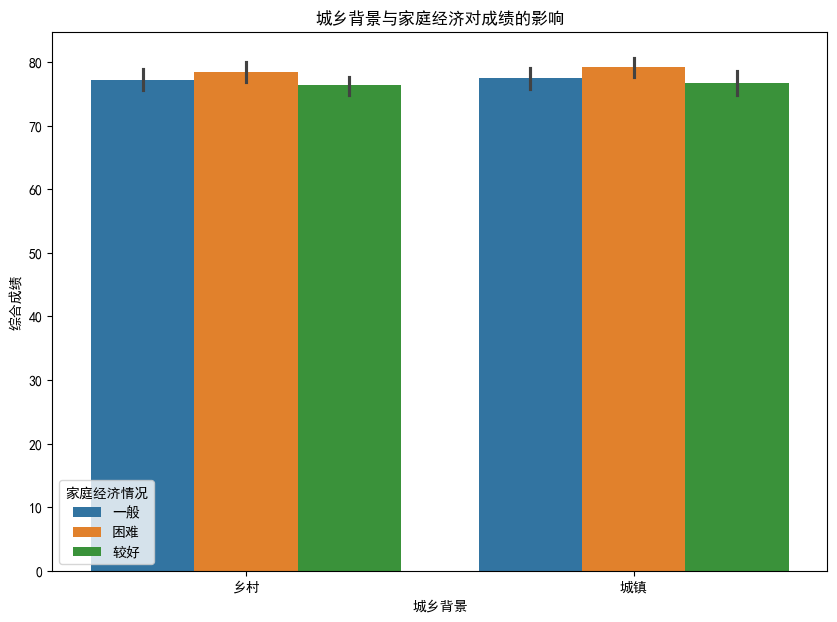

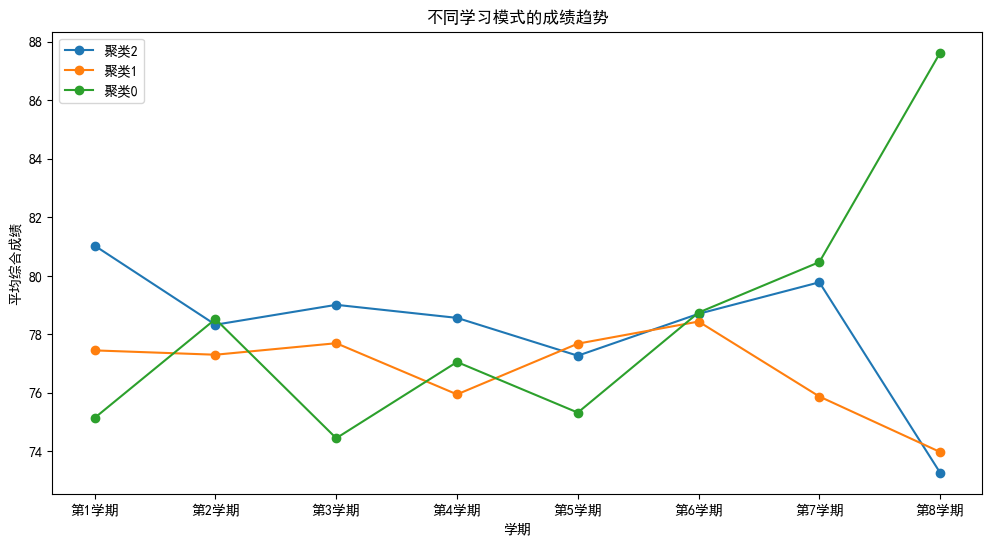

In [5]:
# 指定中文字体
plt.rcParams["font.family"] = ["SimHei",  "sans-serif"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

class StudentBehaviorAnalyzer:
    def __init__(self):
        self.data = {}  # 存储原始数据
        self.merged_data = None  # 存储合并后的数据
        self.cluster_labels = None  # 聚类标签

    def load_data(self, file_paths):
        """加载并清洗数据"""
        data = {
            'academic': pd.read_csv(file_paths['academic']),
            'library': pd.read_csv(file_paths['library']),
            'digital': pd.read_csv(file_paths['digital']),
            'social': pd.read_csv(file_paths['social']),
            'background': pd.read_csv(file_paths['background'])
        }
        
        # 数据清洗：剔除异常成绩（补考/重修）
        data['academic'] = data['academic'][
            (data['academic']['考试成绩'] >= 50) & (data['academic']['考试成绩'] <= 100)
        ]
        
        # 标记学习中断期（出勤率<0.6）
        data['academic']['学习中断期'] = data['academic']['出勤率'].apply(lambda x: 1 if x < 0.6 else 0)
        
        # 转换时间格式
        data['library']['入馆时间'] = pd.to_datetime(data['library']['入馆时间'])
        data['digital']['访问日期'] = pd.to_datetime(data['digital']['访问日期'])
        data['social']['互动日期'] = pd.to_datetime(data['social']['互动日期'])
        
        self.data = data
        print("数据加载并清洗完成！")
        return data

    def preprocess_data(self):
        """数据预处理与特征工程"""
        academic = self.data['academic']
        library = self.data['library']
        digital = self.data['digital']
        social = self.data['social']
        background = self.data['background']
        
        # 1. 学业数据特征：计算综合成绩（考试占70%，课堂表现占30%）
        academic['综合成绩'] = academic['考试成绩'] * 0.7 + academic['课堂表现评分'] * 0.3
        
        # 2. 图书馆数据特征：按学生/学期聚合
        library['学期'] = library['入馆时间'].dt.to_period('Q').astype(str)  # 按季度分组（可改为学期）
        library_features = library.groupby(['学生ID', '学期']).agg({
            '停留时长（小时）': 'sum',
            '借阅图书数量': 'sum',
            '入馆时间': 'count'
        }).reset_index().rename(columns={'入馆时间': '入馆次数'})
        
        # 3. 电子资源特征：按学生/学期聚合
        digital['学期'] = digital['访问日期'].dt.to_period('Q').astype(str)
        digital_features = digital.groupby(['学生ID', '学期']).agg({
            '使用时长（小时）': 'sum',
            '资源类型': 'count'
        }).reset_index().rename(columns={'资源类型': '资源访问次数'})
        
        # 4. 社交协作特征：按学生/学期聚合
        social['学期'] = social['互动日期'].dt.to_period('Q').astype(str)
        social_features = social.groupby(['学生ID', '学期']).agg({
            '互动次数': 'sum',
            '互动类型': 'count'
        }).reset_index().rename(columns={'互动类型': '互动总次数'})
        
        # 5. 合并所有数据
        merged = pd.merge(academic, background, on='学生ID', how='left')
        merged = pd.merge(merged, library_features, on=['学生ID', '学期'], how='left')
        merged = pd.merge(merged, digital_features, on=['学生ID', '学期'], how='left')
        merged = pd.merge(merged, social_features, on=['学生ID', '学期'], how='left')
        
        # 使用0填充缺失值
        merged.fillna(0, inplace=True)
        # columns_to_drop = ['学生ID', '学期']
        # numeric_cols = merged.select_dtypes(include=[np.number]).columns.drop(['学生ID', '学期'])
        # merged[numeric_cols] = merged[numeric_cols].apply(lambda x: x.fillna(x.mean()))
        
        self.merged_data = merged
        print(f"合并后数据维度：{merged.shape}")
        return merged

    def exploratory_data_analysis(self):
        """探索性数据分析"""
        if self.merged_data is None:
            raise ValueError("请先预处理数据")
        
        # 1. 成绩分布
        # plt.figure(figsize=(12, 6))
        # sns.boxplot(x='学期', y='综合成绩', data=self.merged_data)
        # plt.title('各学期综合成绩分布')
        # plt.savefig('score_distribution.png')
        # 1. 成绩分布
        plt.figure(figsize=(10, 6))
        # 计算各学期的平均成绩
        semester_avg = self.merged_data.groupby('学期')['综合成绩'].mean().reset_index()
        # 使用柱状图展示平均成绩
        sns.barplot(x='学期', y='综合成绩', data=semester_avg, palette='viridis')
        # 在柱状图上方添加数值标签
        for i, v in enumerate(semester_avg['综合成绩']):
            plt.text(i, v + 1, f'{v:.1f}', ha='center')
        plt.title('各学期综合成绩分布')
        plt.savefig('score_distribution.png')
        
        #2. 学习投入与成绩相关性
        # plt.figure(figsize=(10, 7))
        # corr_matrix = self.merged_data[['综合成绩', '停留时长（小时）', '使用时长（小时）', '互动次数']].corr()
        # sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        # plt.title('学习投入与成绩相关性')
        # plt.savefig('correlation_heatmap.png')
        
        # 2. 学习投入与成绩相关性
        plt.figure(figsize=(12, 10))  # 调整图形大小
        # 创建散点图矩阵
        g = sns.pairplot(
            self.merged_data,
            vars=['综合成绩', '停留时长（小时）', '使用时长（小时）', '互动次数'],
            diag_kind='kde',  # 对角线上使用核密度估计图
            kind='scatter',   # 非对角线上使用散点图
            palette='viridis', # 设置调色板
            plot_kws={'alpha': 0.5, 's': 30, 'edgecolor': 'w'}  # 设置散点图样式
        )
        # 添加标题
        plt.subplots_adjust(top=0.95)
        g.fig.suptitle('学习投入与成绩的关系', fontsize=16)
        # 调整轴标签字体大小
        for ax in g.axes.flatten():
            ax.set_xlabel(ax.get_xlabel(), fontsize=12)
            ax.set_ylabel(ax.get_ylabel(), fontsize=12)
        plt.savefig('scatter_matrix.png')
        
        # 3. 城乡背景与成绩差异
        plt.figure(figsize=(10, 7))
        sns.barplot(x='城乡背景', y='综合成绩', hue='家庭经济情况', data=self.merged_data)
        plt.title('城乡背景与家庭经济对成绩的影响')
        plt.savefig('background_vs_score.png')

    def prepare_time_series(self):
        """准备时序分析数据（学生-学期成绩矩阵）"""
        if self.merged_data is None:
            raise ValueError("请先预处理数据")
        
        # 提取学期列表并排序
        unique_semesters = sorted(self.merged_data['学期'].unique(), key=lambda x: int(x.split('第')[1].split('学期')[0]))
        
        # 构建学生-学期矩阵
        student_matrix = self.merged_data.pivot(
            index='学生ID', 
            columns='学期', 
            values='综合成绩'
        )[unique_semesters].fillna(method='ffill').fillna(method='bfill')
        
        # 标准化成绩序列
        scaler = StandardScaler()
        self.time_series_data = scaler.fit_transform(student_matrix)
        return self.time_series_data

        # 生成时间序列数据前，确定有效样本的索引
        self.valid_indices = self.merged_data.index[self.merged_data['is_valid'] == True].tolist()
        
        # 仅使用有效样本生成时间序列数据
        self.time_series_data = []
        for idx in self.valid_indices:
            student_data = self.merged_data.iloc[idx]
            # 生成时间序列的逻辑
            time_series = self.generate_time_series(student_data)
            self.time_series_data.append(time_series)

        self.merged_data = self.merged_data.iloc[valid_indices].reset_index(drop=True)
        # 同步过滤 merged_data（关键步骤！）

    def dtw_clustering(self, n_clusters=3):
        """基于DTW的时序聚类分析"""
        if not hasattr(self, 'time_series_data'):
            self.prepare_time_series()

        
        # 计算DTW距离矩阵
        n_students = len(self.time_series_data)
        dtw_dist = np.zeros((n_students, n_students))
        
        for i in range(n_students):
            for j in range(i, n_students):
                if i == j:
                    dtw_dist[i, j] = 0
                else:
                    alignment = dtw(
                        self.time_series_data[i], 
                        self.time_series_data[j], 
                        dist_method='euclidean'
                    )
                    dist = alignment.distance 
                    dtw_dist[i, j] = dist
                    dtw_dist[j, i] = dist
        
        # 标准化距离矩阵
        scaler = StandardScaler()
        dtw_dist_scaled = scaler.fit_transform(dtw_dist)
        
        # K-means聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = kmeans.fit_predict(dtw_dist_scaled)

        print(f"DTW 距离矩阵形状：{dtw_dist.shape}")
        print(f"聚类标签数量：{len(self.cluster_labels)}")
        print(f"DataFrame 长度：{len(self.merged_data)}")

        # 假设 cluster_labels 是按学生分配的（100 个）
        student_ids = self.merged_data['学生ID'].unique()
        label_map = dict(zip(student_ids, self.cluster_labels))  # 映射 学生ID -> 聚类标签

        # 根据学生ID映射到每一行
        # 保存聚类结果
        self.merged_data['cluster'] = self.merged_data['学生ID'].map(label_map)
        print(f"聚类完成，各聚类人数：{pd.Series(self.cluster_labels).value_counts()}")

    def analyze_clusters(self):
        """分析聚类结果（学习模式）"""
        if self.cluster_labels is None:
            raise ValueError("请先进行聚类分析")
        
        # 按聚类分组统计特征
        cluster_stats = self.merged_data.groupby('cluster').agg({
            '综合成绩': ['mean', 'std'],
            '停留时长（小时）': 'mean',
            '使用时长（小时）': 'mean',
            '互动次数': 'mean',
            '学习动机评分': 'mean',
            '自律性评分': 'mean',
            '学习中断期': 'sum'
        }).reset_index()
        
        cluster_stats.columns = ['cluster', '平均成绩', '成绩波动', '平均图书馆时长', 
                                '平均电子资源时长', '平均互动次数', '平均学习动机', 
                                '平均自律性', '学习中断次数']
        
        print("\n各类学习模式特征统计：")
        print(cluster_stats.sort_values('平均成绩', ascending=False))
        
        # 绘制典型聚类的成绩趋势
        plt.figure(figsize=(12, 6))
        for cluster in self.merged_data['cluster'].unique():
            cluster_series = self.merged_data[
                self.merged_data['cluster'] == cluster
            ].groupby('学期')['综合成绩'].mean()
            plt.plot(cluster_series.index, cluster_series.values, 'o-', label=f'聚类{cluster}')
        
        plt.title('不同学习模式的成绩趋势')
        plt.xlabel('学期')
        plt.ylabel('平均综合成绩')
        plt.legend()
        plt.savefig('cluster_trends.png')

    def run_analysis(self, file_paths):
        """执行完整分析流程"""
        # 1. 加载并清洗数据
        self.load_data(file_paths)
        
        # 2. 数据预处理与合并
        self.preprocess_data()
        
        # 3. 探索性数据分析
        self.exploratory_data_analysis()
        
        # 4. 时序聚类分析（默认3类）
        self.dtw_clustering()
        
        # 5. 学习模式分析
        self.analyze_clusters()

# 执行分析（替换为您的文件路径）
if __name__ == "__main__":
    file_paths = {
        'academic': 'academic_performance.csv',
        'library': 'library_usage.csv',
        'digital': 'digital_resources.csv',
        'social': 'social_collaboration.csv',
        'background': 'background_psychology.csv'
    }
    
    analyzer = StudentBehaviorAnalyzer()
    analyzer.run_analysis(file_paths)